In [1]:
import glob
import unicodedata
import string

In [2]:
def find_files(path): return glob.glob(path)
print(find_files('./data/names/*.txt'))

['./data/names/Arabic.txt', './data/names/English.txt', './data/names/German.txt', './data/names/Vietnamese.txt', './data/names/Italian.txt', './data/names/Czech.txt', './data/names/Scottish.txt', './data/names/Dutch.txt', './data/names/Korean.txt', './data/names/Chinese.txt', './data/names/Greek.txt', './data/names/Irish.txt', './data/names/French.txt', './data/names/Portuguese.txt', './data/names/Russian.txt', './data/names/Japanese.txt', './data/names/Polish.txt', './data/names/Spanish.txt']


In [4]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode2ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicode2ascii("Ślusàrski"))

Slusarski


In [12]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode2ascii(line) for line in lines]

for filename in find_files('./data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [14]:
print(category_lines['Korean'][:5])

['Ahn', 'Baik', 'Bang', 'Byon', 'Cha']


In [18]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter2index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter2tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter2index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line2tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter2index(letter)] = 1
    return tensor

In [19]:
print(letter2tensor('J'))



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     1     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]



In [22]:
print(line2tensor('keon').size())

torch.Size([4, 1, 57])


In [36]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
print("n_letters:", n_letters, "n_hidden:", n_hidden, "n_categories:", n_categories)
print(rnn)

n_letters: 57 n_hidden: 128 n_categories: 18
RNN (
  (i2h): Linear (185 -> 128)
  (i2o): Linear (185 -> 18)
  (softmax): LogSoftmax ()
)


In [37]:
input = Variable(line2tensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

Variable containing:

Columns 0 to 9 
-2.8618 -2.8753 -2.8834 -2.9676 -2.9437 -2.9598 -2.9653 -2.7539 -2.9182 -2.9475

Columns 10 to 17 
-2.9105 -2.7830 -2.9466 -2.8541 -2.9486 -2.8439 -2.8831 -2.8162
[torch.FloatTensor of size 1x18]



In [38]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i
print(category_from_output(output))

('Dutch', 7)


In [39]:
import random

def choose(l):
    return l[random.randint(0, len(l) - 1)]

def training_pair():                                                                                                               
    category = choose(all_categories)
    line = choose(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line2tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = training_pair()
    print('category :', category, ' \tname:', line)

category : Polish  	name: Rusnak
category : Czech  	name: Silhan
category : Japanese  	name: Ihara
category : Japanese  	name: Sassa
category : Portuguese  	name: Castro
category : Irish  	name: Maurice
category : Scottish  	name: Davidson
category : Polish  	name: Sokolsky
category : Portuguese  	name: Maria
category : Spanish  	name: Castillo


In [40]:
criterion = nn.NLLLoss()

In [46]:
learning_rate = 0.005
def train (categroy_tensor, line_tensor):
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    return output, loss.data[0]

In [47]:
import time
import math

In [48]:
n_epochs = 100000
print_every = 5000
plot_every = 1000

rnn = RNN(n_letters, n_hidden, n_categories)

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    category, line, category_tensor, line_tensor = training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


5000 5% (0m 7s) 2.4473 Tholberg / Russian ✗ (Dutch)
10000 10% (0m 14s) 2.9370 Higginson / Russian ✗ (English)
15000 15% (0m 22s) 2.5217 Muir / Korean ✗ (Scottish)
20000 20% (0m 29s) 1.0506 Reuter / German ✓
25000 25% (0m 36s) 2.2771 Korycansky / Polish ✗ (Czech)
30000 30% (0m 42s) 4.4783 Daal / Vietnamese ✗ (Dutch)
35000 35% (0m 49s) 1.4944 Bang / Chinese ✗ (Korean)
40000 40% (0m 57s) 1.8069 Nymmik / Polish ✗ (Russian)
45000 45% (1m 4s) 1.4673 San / Chinese ✗ (Korean)
50000 50% (1m 11s) 4.1062 Tovma / Spanish ✗ (Russian)
55000 55% (1m 18s) 0.4954 Suk / Korean ✓
60000 60% (1m 24s) 0.1622 O'Donoghue / Irish ✓
65000 65% (1m 31s) 1.5637 Kattan / Arabic ✓
70000 70% (1m 38s) 0.0953 Lupekhin / Russian ✓
75000 75% (1m 45s) 1.2902 Artz / Spanish ✗ (German)
80000 80% (1m 52s) 0.3286 Ankeren / Dutch ✓
85000 85% (1m 58s) 3.0084 Leggett / French ✗ (English)
90000 90% (2m 6s) 0.2628 Dam / Vietnamese ✓
95000 95% (2m 12s) 1.3248 Vennen / English ✗ (Dutch)
100000 100% (2m 19s) 1.2330 Ton / Chinese ✗ (V

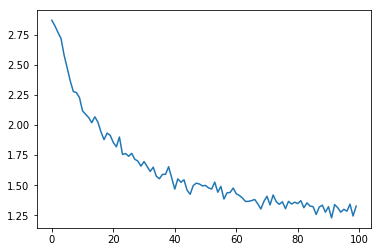

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

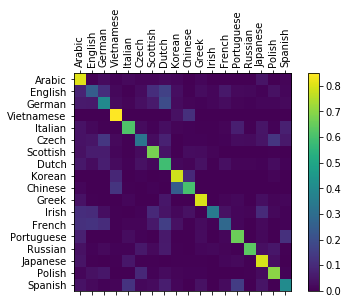

In [50]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [51]:

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(line2tensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-1.03) Czech
(-1.25) Russian
(-1.39) Polish

> Jackson
(-0.21) Scottish
(-2.41) English
(-3.27) Russian

> Satoshi
(-1.16) Italian
(-1.68) Arabic
(-1.77) Japanese
